# **Classification of Documents Using Graph-Based Features and KNN**

## **1. Data Collection and Preparation:**
Collect or create 15 pages of text for each of the three assigned topics, ensuring each
page contains approximately 500 words.

Import necessary libraries

In [3]:
import os
import csv
import pandas as pd

Read the data from the files

In [4]:
food_csv_file_path  = './DiseasesAndSymptomsData.csv'
disease_csv_file_path  = './FooDData.csv'
science_csv_file_path  = './SportsData.csv'

# Read in the data
food_articles = pd.read_csv(food_csv_file_path, encoding='latin1')
disease_articles = pd.read_csv(disease_csv_file_path , encoding='latin1' )
science_articles = pd.read_csv(science_csv_file_path , encoding='latin1')

# Display the shape of the data
print(food_articles.shape)
print(disease_articles.shape)
print(science_articles.shape)

# Display the columns of the data
print(food_articles.columns)

# Display the first few rows of the data
print(food_articles.head())

(15, 5)
(14, 5)
(15, 5)
Index(['Title', 'Text', 'Word Count', 'Topic', 'Link'], dtype='object')
                       Title  \
0        Atrial fibrillation   
1  Abdominal aortic aneurysm   
2              Hyperhidrosis   
3                  Achalasia   
4    Achilles tendon rupture   

                                                Text  Word Count  \
0  In a typical heart, a tiny group of cells at t...         919   
1  An abdominal aortic aneurysm occurs when a low...         555   
2  Hyperhidrosis (hi-pur-hi-DROE-sis) is excessiv...         638   
3  Achalasia is a rare disorder that makes it dif...         437   
4  The Achilles tendon is a strong fibrous cord t...         876   

                   Topic                                               Link  
0  Diseases And Symptoms  https://www.mayoclinic.org/diseases-conditions...  
1  Diseases And Symptoms  https://www.mayoclinic.org/diseases-conditions...  
2  Diseases And Symptoms  https://www.mayoclinic.org/diseases-condit

In [12]:
# Divide each dataset into training and test sets
train_food = food_articles[:12]
test_food = food_articles[12:15]

train_disease = disease_articles[:12]
test_disease = disease_articles[12:15]

train_science = science_articles[:12]
test_science = science_articles[12:15]

In [13]:
# Concatenate the training and test sets for each topic
train_set = pd.concat([train_food, train_disease, train_science], ignore_index=True)
test_set = pd.concat([test_food, test_disease, test_science], ignore_index=True)

Divide the dataset into a training set (12 pages per topic) and a test set (3 pages per 
topic).

In [7]:
# from sklearn.model_selection import train_test_split

# Split the dataset into training set and test set
# train_set = articles_data.iloc[:12]  # Access the first 12 rows
# test_set = articles_data.iloc[12:]   # Access the remaining rows

# Print the number of articles in each set
print("Training set size:", len(train_set))
print("Test set size:", len(test_set))

Training set size: 36
Test set size: 8


In [14]:
# print the 12th article in the training set
print(train_set.iloc[12])

Title         \n75 Spring Weeknight Dinners That Are Fresh a...
Text          \nFrom satisfying mains (that are a little lig...
Word Count                                                  267
Topic                                                      Food
Link          https://www.foodnetwork.com/recipes/photos/spr...
Name: 12, dtype: object


## **2. Preprocessing**
Preprocessing such as tokenization, stop-word removal, and stemming

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

In [1]:
# Tokenization
def tokenize(text):
    return nltk.word_tokenize(str(text).lower())

# Stop-word removal
def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    return filtered_tokens

# Stemming
def stem_tokens(tokens):
    stemmer = PorterStemmer()
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return stemmed_tokens

In [19]:
# Preprocess train dataset
preprocessed_train_set = []
for index, row in train_set.iterrows():  # Iterate over each row in the training set DataFrame
    title_tokens = tokenize(row['Title'])  # Access the 'title' column of the current row
    body_tokens = tokenize(row['Text'])    # Access the 'body' column of the current row

    title_tokens = remove_stopwords(title_tokens)
    body_tokens = remove_stopwords(body_tokens)

    title_tokens = stem_tokens(title_tokens)
    body_tokens = stem_tokens(body_tokens)

    words_count = len(body_tokens)
    
    preprocessed_train_set.append({'Topic': row['Topic'], 'title_tokens': title_tokens, 'body_tokens': body_tokens, 'words_count': words_count})


# Print preprocessed train dataset
for index, article in enumerate(preprocessed_train_set):
    print(f"Article: {index + 1}")
    print(f"Label: {article['Topic']}")
    print(f"Title Tokens: {article['title_tokens']}")
    print(f"Body Tokens: {article['body_tokens']}")
    print(f"Words Count: {article['words_count']}")
    print()

Article: 1
Label: Diseases And Symptoms
Title Tokens: ['atrial', 'fibril']
Body Tokens: ['typic', 'heart', ',', 'tini', 'group', 'cell', 'sinu', 'node', 'send', 'electr', 'signal', '.', 'signal', 'travel', 'heart', "'s", 'upper', 'chamber', 'atrioventricular', '(', 'av', ')', 'node', '.', 'signal', 'pass', 'lower', 'heart', 'chamber', ',', 'caus', 'squeez', 'pump', 'blood', '.', 'atrial', 'fibril', ',', 'electr', 'signal', 'fire', 'mani', 'locat', 'upper', 'chamber', ',', 'caus', 'beat', 'chaotic', '.', 'sinc', 'av', 'node', "n't", 'prevent', 'chaotic', 'signal', 'enter', 'lower', 'chamber', ',', 'heart', 'beat', 'faster', 'irregularly.in', 'typic', 'heart', ',', 'tini', 'group', 'cell', 'sinu', 'node', 'send', 'electr', 'signal', '.', 'signal', 'travel', 'heart', "'s", 'upper', 'chamber', 'atrioventricular', '(', 'av', ')', 'node', '.', 'signal', 'pass', 'lower', 'heart', 'chamber', ',', 'caus', 'squeez', 'pump', 'blood', '.', 'atrial', 'fibril', ',', 'electr', 'signal', 'fire', 'mani

## **3. Graph Construction:**
Represent each page as a directed graph where nodes represent unique terms = (words), (around 300 words, after preprocessing such as 
tokenization, stop-word removal, and stemming) and edges denote term relationships based on their sequence in the text

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

In [21]:
# Function to build directed graph
def build_graph(tokens):
    graph = nx.DiGraph()
    for i in range(len(tokens) - 1):
        if not graph.has_edge(tokens[i], tokens[i+1]):
            graph.add_edge(tokens[i], tokens[i+1], weight=1)
        else:
            graph.edges[tokens[i], tokens[i+1]]['weight'] += 1
    return graph

In [22]:
# Function to construct directed graph
def construct_graph(tokens):
    graph = nx.DiGraph()
    # Add nodes
    for i, token in enumerate(tokens):
        graph.add_node(token)
        if i > 0:
            # Add directed edge from previous token to current token
            graph.add_edge(tokens[i-1], token)
    return graph

In [23]:
# Function to plot the graph
def plot_graph(graph):
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_color='skyblue', node_size=1500, edge_color='black', linewidths=1, font_size=10)
    labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    plt.show()

Article :  1 Graph built
Article :  2 Graph built
Article :  3 Graph built
Article :  4 Graph built
Article :  5 Graph built
Article :  6 Graph built
Article :  7 Graph built
Article :  8 Graph built
Article :  9 Graph built
Article :  10 Graph built
Article :  11 Graph built
Article :  12 Graph built
Article :  13 Graph built
Article :  14 Graph built
Article :  15 Graph built
Article :  16 Graph built
Article :  17 Graph built
Article :  18 Graph built
Article :  19 Graph built
Article :  20 Graph built
Article :  21 Graph built
Article :  22 Graph built
Article :  23 Graph built
Article :  24 Graph built
Article :  25 Graph built
Article :  26 Graph built
Article :  27 Graph built
Article :  28 Graph built
Article :  29 Graph built
Article :  30 Graph built
Article :  31 Graph built
Article :  32 Graph built
Article :  33 Graph built
Article :  34 Graph built
Article :  35 Graph built
Article :  36 Graph built
Graph of the first article in the training set


c:\Users\SONIC LAPTOPS\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 151 (\x97) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


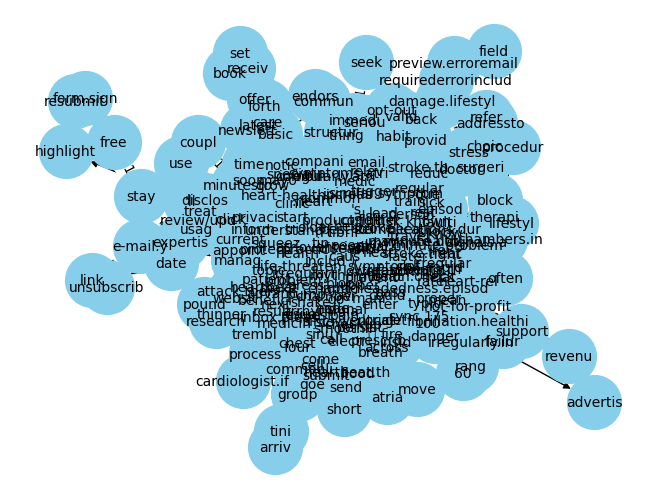

In [24]:
graphs_train_set = []
for index, article in enumerate(preprocessed_train_set):
    # Build the directed graph
    print("Article : ", index+1, "Graph built")
    graph = build_graph(article['body_tokens'])
    graphs_train_set.append(graph)

    # Plot the graph
    # plot_graph(graph)

# Plot the first graph in the training set
print("Graph of the first article in the training set")
plot_graph(graphs_train_set[0])


## **4. Graph Representation:**

In [ ]:
import gravis as gv
graph = graphs_train_set[0]
gv.d3(graph).display() 

ModuleNotFoundError: No module named 'gravis'

## **4. Feature Extraction via Common Subgraphs:**
Utilize frequent subgraph mining techniques to identify common subgraphs within the training set graphs. These common subgraphs will serve as features for classification, capturing the shared content across documents related to the same topic.

## **5. Training KNN Classifier:**

In [25]:
import networkx as nx
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

In [26]:
# Function to compute MCS between two graphs
def compute_mcs(graph1, graph2):
    # Extract the set of edges from each graph
    edges1 = set(graph1.edges())
    edges2 = set(graph2.edges())
    
    # Compute the set of common edges between the two graphs
    common_edges = edges1.intersection(edges2)
    
    # Construct a new graph using the common edges, representing the maximal common subgraph
    mcs_graph = nx.Graph(list(common_edges))
    
    # Calculate the graph distance (negative size of the maximal common subgraph)
    distance = -len(mcs_graph.edges())
    
    return distance

In [27]:
# Function to compute distances between test graph and all training graphs
def compute_distances(test_graph, training_graphs):
    distances = []
    for training_graph in training_graphs:
        mcs = compute_mcs(test_graph, training_graph)
        # Convert MCS to a distance measure and normalize
        if mcs == 0:
            distance = 0
        else:
            distance = 1 - (mcs / max(len(test_graph.edges()), len(training_graph.edges())))
        distances.append(distance)
    return distances

In [28]:
# Function to train the classifier
def train_classifier(training_graphs, training_labels):
    # Compute the feature vectors for the training graphs
    feature_vectors = []
    for graph in training_graphs:
        feature_vector = []
        # Append the entire graph structure to the feature vector
        # feature_vector.append(graph)
        # Append the set of nodes to the feature vector
        feature_vector.append(len(graph.nodes()))
        feature_vector.append(len(graph.edges()))  # Number of edges
        feature_vector.append(compute_distances(graph, training_graphs)[0])  # Index of the closest match
        feature_vector.append(np.mean(list(dict(graph.degree()).values())))  # Mean degree
        feature_vector.append(np.std(list(dict(graph.degree()).values())))  # Standard deviation of degree
        feature_vector.append(np.mean(list(nx.clustering(graph).values())))  # Mean clustering coefficient
        feature_vector.append(np.std(list(nx.clustering(graph).values())))  # Standard deviation of clustering coefficient
        feature_vectors.append(feature_vector)
    
    # Train a k-NN classifier
    classifier = KNeighborsClassifier(n_neighbors=3)
    classifier.fit(feature_vectors, training_labels)
    
    return classifier

In [30]:
# train the classifier
training_labels = train_set['label'].tolist()
classifier = train_classifier(graphs_train_set, training_labels)

KeyError: 'label'

## **6. Classification with KNN:**

In [ ]:
# Function to predict the label of a test graph
def predict_label(test_graph, classifier):
    # Compute the feature vector for the test graph
    feature_vector = []
    feature_vector.append(len(test_graph.nodes()))
    feature_vector.append(len(test_graph.edges())) # Number of edges
    feature_vector.append(compute_distances(test_graph, graphs_train_set)[0])  # Index of the closest match
    feature_vector.append(np.mean(list(dict(test_graph.degree()).values())))  # Mean degree
    feature_vector.append(np.std(list(dict(test_graph.degree()).values())))  # Standard deviation of degree
    feature_vector.append(np.mean(list(nx.clustering(test_graph).values())))  # Mean clustering coefficient
    feature_vector.append(np.std(list(nx.clustering(test_graph).values())))  # Standard deviation of clustering coefficient
    
    # Predict the label of the test graph
    predicted_label = classifier.predict([feature_vector])
    
    return predicted_label[0]

In [ ]:
# Preprocess test dataset
preprocessed_test_set = []
for index, row in test_set.iterrows():
    title_tokens = tokenize(row['title'])
    body_tokens = tokenize(row['body'])
    
    title_tokens = remove_stopwords(title_tokens)
    body_tokens = remove_stopwords(body_tokens)
    
    title_tokens = stem_tokens(title_tokens)
    body_tokens = stem_tokens(body_tokens)
    
    words_count = len(body_tokens)
    
    preprocessed_test_set.append({'label': row['label'], 'title_tokens': title_tokens, 'body_tokens': body_tokens, 'words_count': words_count})

In [ ]:
# Print preprocessed test dataset
for article in preprocessed_test_set:
    print(f"Label: {article['label']}")
    print(f"Title Tokens: {article['title_tokens']}")
    print(f"Body Tokens: {article['body_tokens']}")
    print(f"Words Count: {article['words_count']}")
    print()

Label: Food
Title Tokens: ['6', '``', 'healthi', "''", 'kid', 'snack', '’']
Body Tokens: ['feed', 'kid', 'get', 'confus', '.', 'pushi', 'food', 'market', 'bewild', 'label', ',', '’', 'wonder', 'folk', 'misl', 'kid', 'snack', 'realli', 'healthi', '.', "'s", 'real', 'deal', "'ve", 'buy', '.', '#', '1', ':', 'yogurt', 'cow', '’', 'make', 'purpl', ',', 'hot', 'pink', 'even', 'blue-color', 'yogurt', '—', '’', 'tell', 'kid', 'everi', 'time', 'hit', 'dairi', 'aisl', '.', 'neon', 'yogurt', 'load', 'sugar', '(', 'includ', 'infam', 'high', 'fructos', 'corn', 'syrup', ')', 'lot', 'addit', 'preserv', "n't", 'favor', 'littl', 'bodi', '.', 'give', 'kid', 'punch', 'calcium', 'protein', 'healthier', 'dairi', 'product', '.', 'kid', 'pine', 'yogurt', ',', 'healthier', 'option', ':', 'stonyfield', 'yo', 'babi', ',', 'yo', 'kid', 'fat-fre', 'organ', '(', 'french', 'vanilla', '5-year-old', "'s", 'fave', ')', 'low-fat', 'brown', 'cow', 'yogurtchobani', 'champion', 'greek', 'yogurt', '#', '2', ':', 'granola'

Article :  1 Graph built
Article :  2 Graph built
Article :  3 Graph built
Article :  4 Graph built
Article :  5 Graph built
Article :  6 Graph built
Article :  7 Graph built
Article :  8 Graph built
Article :  9 Graph built
Graph of the first article in the training set


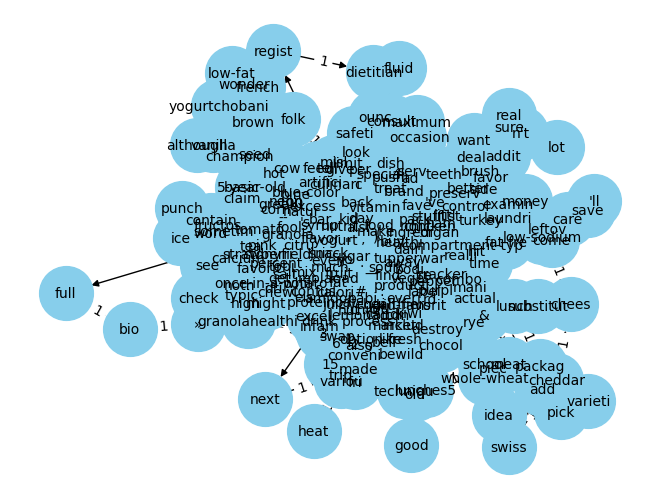

In [ ]:
# Construct graphs for the test set
graphs_test_set = []
for index, article in enumerate(preprocessed_test_set):
    # Build the directed graph
    print("Article : ", index+1, "Graph built")
    graph = build_graph(article['body_tokens'])
    graphs_test_set.append(graph)

    # Plot the graph
    # plot_graph(graph)

# Plot the first graph in the training set
print("Graph of the first article in the training set")
plot_graph(graphs_test_set[0])

In [ ]:
# Predict the labels of the test graphs
predicted_labels = []
for test_graph in graphs_test_set:
    predicted_label = predict_label(test_graph, classifier)
    predicted_labels.append(predicted_label)

## **7. Evaluation:**

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, 

Predicted Labels vs Actual Labels:
Predicted: Science/Education, Actual: Food
Predicted: Diseases/ Symptoms, Actual: Food
Predicted: Diseases/ Symptoms, Actual: Food
Predicted: Diseases/ Symptoms, Actual: Diseases/ Symptoms
Predicted: Diseases/ Symptoms, Actual: Diseases/ Symptoms
Predicted: Diseases/ Symptoms, Actual: Diseases/ Symptoms
Predicted: Diseases/ Symptoms, Actual: Science/Education
Predicted: Science/Education, Actual: Science/Education
Predicted: Diseases/ Symptoms, Actual: Science/Education

Accuracy: 0.4444444444444444
Precision: 0.30952380952380953
Recall: 0.4444444444444444
F1-score: 0.3333333333333333

Classification Report:
                    precision    recall  f1-score   support

Diseases/ Symptoms       0.43      1.00      0.60         3
              Food       0.00      0.00      0.00         3
 Science/Education       0.50      0.33      0.40         3

          accuracy                           0.44         9
         macro avg       0.31      0.44      0.

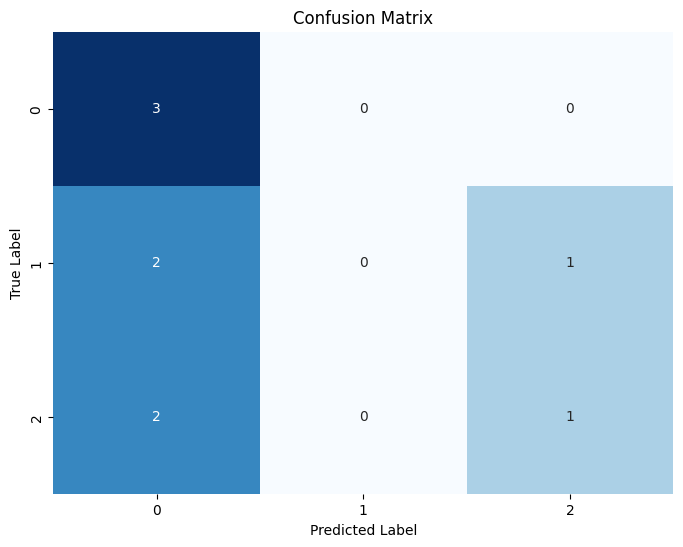

In [ ]:
# Calculate evaluation metrics  
y_true = test_set['label'].tolist()
y_pred = predicted_labels

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
report = classification_report(y_true, y_pred)

# Print the predicted labels and actual labels
print("Predicted Labels vs Actual Labels:")
for i in range(len(predicted_labels)):
    print(f"Predicted: {predicted_labels[i]}, Actual: {y_true[i]}")
print()

# Print evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print()

# Print classification report
print("Classification Report:")
print(report)
print()

# Plot confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()